# Step 0.0. Install LightAutoML

In [ ]:
!pip install -U lightautoml

# Step 0.1. Import necessary libraries 

In [2]:
# Standard python libraries
import os
import time

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

# Step 0.2. Parameters 

In [3]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 1800 # Time in seconds for automl run
TARGET = 'loan_default' # Target column name

# Step 0.3. Fix torch number of threads and numpy seed 

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data load 

In [5]:
%%time
pd.set_option('display.max_columns', 100)
train_data = pd.read_csv('../input/ds-masters-math-retake/default_train.csv')
train_data.head()

CPU times: user 756 ms, sys: 110 ms, total: 866 ms
Wall time: 1.2 s


,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [6]:
test_data = pd.read_csv('../input/ds-masters-math-retake/default_test.csv')
test_data.head()

,id,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,1,52603,61300,86.95,67,22807,45,1492,01-06-68,Salaried,16-09-18,6,1998,1,0,0,1,0,0,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0
1,2,49478,57010,89.46,67,22807,45,1497,16-08-84,Salaried,30-08-18,6,1998,1,1,0,0,0,0,738,C-Very Low Risk,10,5,0,79750,187000,187000,0,0,0,0,0,0,23309,0,1,0,1yrs 0mon,2yrs 1mon,4
2,3,53503,62100,87.28,67,22807,45,1498,27-02-83,Self employed,20-09-18,6,1998,1,1,0,0,0,0,688,E-Low Risk,13,8,0,1076657,2277048,2277048,0,0,0,0,0,0,4982,0,1,0,1yrs 10mon,4yrs 7mon,0
3,4,70017,86760,82.99,67,22807,45,1479,10-08-88,Self employed,06-09-18,6,1998,1,0,0,1,0,0,585,I-Medium Risk,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1yrs 9mon,1yrs 9mon,0
4,5,50678,58300,89.88,67,22807,45,1474,01-06-77,Self employed,14-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [7]:
submission = pd.read_csv('../input/ds-masters-math-retake/default_sample_submission.csv')
submission.head()

,id,loan_default
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


# Step 0.5. Add new features

In [8]:
def create_extra_features(data):
    data['DatesDiff'] = (pd.to_datetime(data['DisbursalDate'], format = '%d-%m-%y') - 
                         pd.to_datetime(data['Date.of.Birth'], format = '%d-%m-%y')) / np.timedelta64(1, 'D')
    data.drop(columns = ['DisbursalDate', 'Date.of.Birth'], inplace = True)
    
    for col in ['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH']:
        data[col + '_years'] = data[col].map(lambda x: x.split(' ')[0][:-3]).astype(int)
        data[col + '_mons'] = data[col].map(lambda x: x.split(' ')[1][:-3]).astype(int)
        data[col + '_full_num_mons'] = data[col + '_years'] * 12 + data[col + '_mons']
        
    data['diff_in_mons_num'] = data['CREDIT.HISTORY.LENGTH' + '_full_num_mons'] - data['AVERAGE.ACCT.AGE' + '_full_num_mons']
    
    data['CNS_score_type'] = data['PERFORM_CNS.SCORE.DESCRIPTION'].map(lambda x: ord(x[0]) - ord('A'))
    data['CNS_score_type_no_scored'] = data['PERFORM_CNS.SCORE.DESCRIPTION'].map(
                                            lambda x: x[:10] if x.startswith('Not Scored: ') else x)
    

create_extra_features(train_data)
create_extra_features(test_data)

In [9]:
train_data

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,DatesDiff,AVERAGE.ACCT.AGE_years,AVERAGE.ACCT.AGE_mons,AVERAGE.ACCT.AGE_full_num_mons,CREDIT.HISTORY.LENGTH_years,CREDIT.HISTORY.LENGTH_mons,CREDIT.HISTORY.LENGTH_full_num_mons,diff_in_mons_num,CNS_score_type,CNS_score_type_no_scored
0,50578,58400,89.55,67,22807,45,1441,Salaried,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,12633.0,0,0,0,0,0,0,0,13,No Bureau History Available
1,47145,65550,73.23,67,22807,45,1502,Self employed,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,12110.0,1,11,23,1,11,23,0,8,I-Medium Risk
2,53278,61360,89.63,67,22807,45,1497,Self employed,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,12030.0,0,0,0,0,0,0,0,13,No Bureau History Available
3,57513,66113,88.48,67,22807,45,1501,Self employed,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,9066.0,0,8,8,1,3,15,7,11,L-Very High Risk
4,52378,60300,88.39,67,22807,45,1495,Self employed,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,14901.0,0,0,0,0,0,0,0,13,No Bureau History Available
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209878,38439,52965,74.58,34,20700,48,1051,Self employed,6,3705,1,1,0,0,0,0,738,C-Very Low Risk,2,2,0,7001,14839,14839,0,0,0,0,0,0,0,0,2,0,0yrs 3mon,0yrs 3mon,0,0,13244.0,0,3,3,0,3,3,0,2,C-Very Low Risk
209879,72623,105405,69.73,34,20700,48,1051,Salaried,6,3705,1,1,0,0,0,0,755,C-Very Low Risk,4,4,0,201422,276624,237977,0,0,0,0,0,0,0,0,1,0,0yrs 9mon,1yrs 0mon,0,0,10726.0,0,9,9,1,0,12,3,2,C-Very Low Risk
209880,42894,60334,72.93,34,20700,48,1051,Salaried,6,3705,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,9239.0,0,0,0,0,0,0,0,13,No Bureau History Available
209881,73651,100600,74.95,34,23775,51,990,Self employed,6,3705,1,0,0,1,0,0,825,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0,10914.0,0,6,6,0,6,6,0,0,A-Very Low Risk


# Step 0.6. Data splitting for train-test 

In [10]:
tr_data, te_data = train_test_split(train_data, 
                                     test_size=TEST_SIZE, 
                                     stratify=train_data[TARGET], 
                                     random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (167906, 48), te_data = (41977, 48)


# ========= AutoML preset usage =========


## Step 1. Create Task

In [11]:
%%time
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('binary', metric = acc_score)

CPU times: user 3.05 ms, sys: 0 ns, total: 3.05 ms
Wall time: 2.6 ms


## Step 2. Setup columns roles

In [12]:
%%time

roles = {
    'target': TARGET
}

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


## Step 3. Create AutoML from preset and train on 80% of data

In [13]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 1800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (167906, 48)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1767.6029913425446 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7826514204037878
Linear model: C = 5e-05 score = 0.7830683104043833
Linear model: C = 0.0001 score = 0.7829491989756417
Linear model: C = 0.0005 score = 0.7830087546900125

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7827938417557547
Linear model: C = 5e-05 score = 0.783061850451148
Linear model: C = 0.0001 score = 0.7835085316101367
Linear model: C = 0.0005 score = 0.7836872040737322
Linear model: C = 0.001 score = 0.7834489741222715
Linear model: C = 0.005 score = 0.7834191953783389

===== Start working with fold 2 for Lvl_0_Pip

## Step 4. Predict to validation data and check scores

In [14]:
%%time

test_pred = automl.predict(te_data)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(tr_data[TARGET].values, oof_pred.data[:, 0])))
print('VALID score: {}'.format(acc_score(te_data[TARGET].values, test_pred.data[:, 0])))

Prediction for test data:
array([[0.1685951 ],
       [0.09836732],
       [0.08909526],
       [0.13764949],
       [0.20773   ],
       [0.12484172],
       [0.08959515],
       [0.1992942 ],
       [0.14634766],
       [0.16506152]], dtype=float32)
Shape = (41977, 1)
Check scores...
OOF score: 0.7840696580229414
VALID score: 0.7839054720442147
CPU times: user 8.91 s, sys: 15 ms, total: 8.92 s
Wall time: 3.44 s


Score for `TabularAutoML` is 78.41% accuracy for OOF preds and 78.39% accuracy for validation preds in 8 minutes time. 

## Step 5. Create AutoML with time utilization 

Below we are going to create specific AutoML preset for TIMEOUT utilization (try to spend it as much as possible):

In [15]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 1799.9946620464325 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (167906, 48)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1767.5967831611633 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7826514204037878
Linear model: C = 5e-05 score = 0.7830683104043833
Linear model: C = 0.0001 score = 0.7829491989756417
Linear model: C = 0.0005 score = 0.7830087546900125

===== Start

## Step 6. Predict to validation data and check scores for utilized automl

In [16]:
%%time

test_pred = automl.predict(te_data)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(tr_data[TARGET].values, oof_pred.data[:, 0])))
print('VALID score: {}'.format(acc_score(te_data[TARGET].values, test_pred.data[:, 0])))

Prediction for test data:
array([[0.16277397],
       [0.10110205],
       [0.09686656],
       [0.13924266],
       [0.20566234],
       [0.13305603],
       [0.08988725],
       [0.22741953],
       [0.14805262],
       [0.18487623]], dtype=float32)
Shape = (41977, 1)
Check scores...
OOF score: 0.7840994365895203
VALID score: 0.7838816494747124
CPU times: user 8.44 s, sys: 3.08 ms, total: 8.44 s
Wall time: 3.37 s


Score for `TabularUtilizedAutoML` is 78.41% accuracy for OOF preds and 78.39% accuracy for validation preds in 23.5 minutes. As the validation score is better for `TabularAutoML` for this case, we choose it for final model retrain on full train dataset.

## Step 7. Train on full data 

In [17]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(train_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Start automl preset with listed constraints:
- time: 1800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (209883, 48)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1765.2139074802399 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.782690520999595
Linear model: C = 5e-05 score = 0.7831431498201396
Linear model: C = 0.0001 score = 0.7830478595421302
Linear model: C = 0.0005 score = 0.7829525692641208

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7827858112776044
Linear model: C = 5e-05 score = 0.7833813755151631
Linear model: C = 0.0001 score = 0.7835957786406842
Linear model: C = 0.0005 score = 0.7835243109321771
Linear model: C = 0.001 score = 0.7833813755151631

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 s

## Step 8. Predict for test data and check OOF score

In [18]:
%%time

test_pred = automl.predict(test_data)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(train_data[TARGET].values, oof_pred.data[:, 0])))

Prediction for test data:
array([[0.24235617],
       [0.3815322 ],
       [0.08559681],
       [0.52745163],
       [0.37283877],
       [0.19917758],
       [0.37359193],
       [0.5434454 ],
       [0.2988817 ],
       [0.31130612]], dtype=float32)
Shape = (23271, 1)
Check scores...
OOF score: 0.7841464053782345
CPU times: user 6.57 s, sys: 3.98 ms, total: 6.58 s
Wall time: 2.42 s


## Step 9. Prepare submission

In [19]:
submission[TARGET] = (test_pred.data[:, 0] > 0.5).astype(int)
submission.to_csv('automl_utilized.csv', index = False)

In [20]:
submission

,id,loan_default
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
23266,23267,0
23267,23268,0
23268,23269,0
23269,23270,0


## Step 10. Feature importances 

CPU times: user 160 ms, sys: 3.99 ms, total: 164 ms
Wall time: 178 ms


<AxesSubplot:xlabel='Feature'>

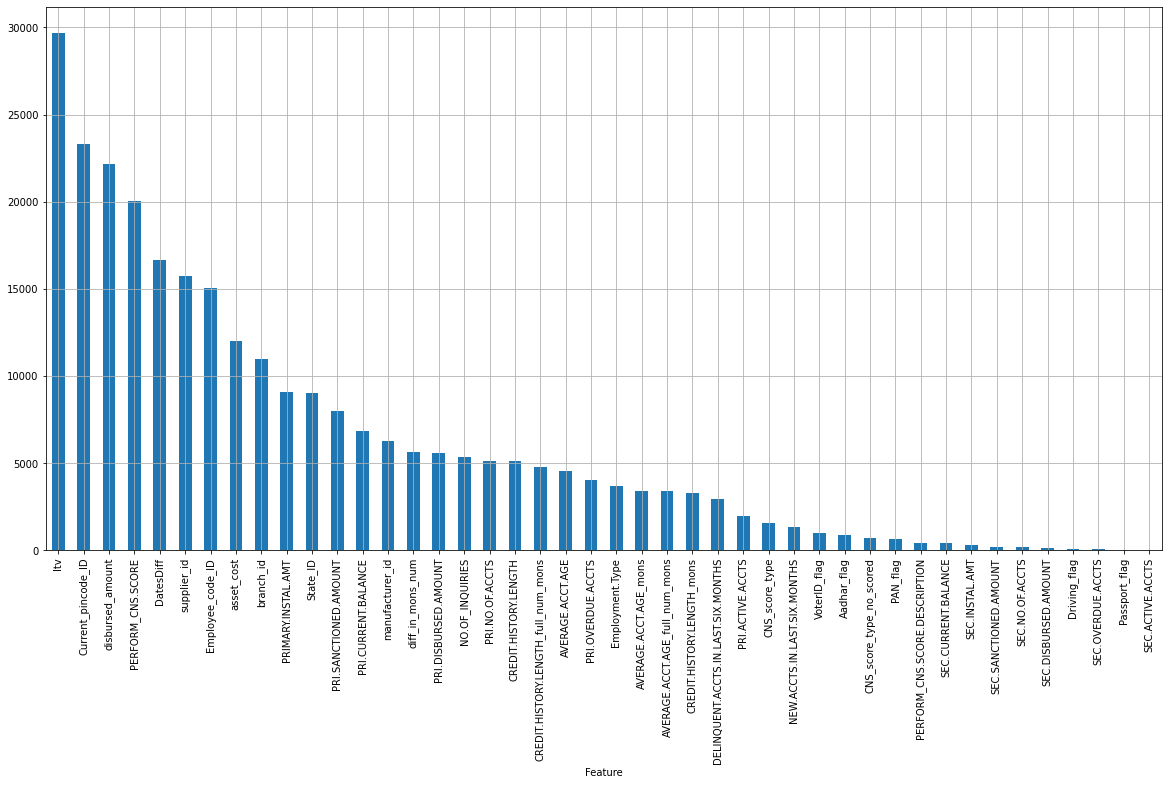

In [21]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)